In [11]:
import sys
import os

# Add the repo root (one level up from notebooks) to Python path
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(repo_root)


# Volatility Demo

**Goals**
- Compute **implied volatility (IV)** from option prices.
- Build and visualize **smiles** (IV vs strike) and **term structures** (IV vs maturity).
- Create a small **volatility surface** from synthetic prices and invert it.
- Do quick **sanity checks** (no-arbitrage bounds, NaN handling, price reconstruction error).


In [12]:
# Setup
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman" # Set font to Times New Roman
from mpl_toolkits.mplot3d import Axes3D  # required for 3D
from options_pricing.black_scholes import black_scholes_price
from options_pricing.volatility import implied_volatility, implied_vol_surface, moneyness_grid

# Reusable base params
S = 100.0
r = 0.01
np.set_printoptions(precision=6, suppress=True)


## 1 Implied volatility from a single option price

Given a market price and contract specs $(S,K,T,r)$, invert the Black–Scholes
formula to get **σ\_imp**. For European options under BS, this is a 1D root find.



In [13]:
K = 100.0
T = 1.0
true_sigma = 0.25

# "Market" price from a known vol (synthetic)
market_call = black_scholes_price(S, K, T, r, true_sigma, option_type="call")

# Invert to IV
iv_call = implied_volatility(price=market_call, S=S, K=K, T=T, r=r, option_type="call")
print("Call market price:", market_call)
print("Recovered IV     :", iv_call)


Call market price: 10.403539152996622
Recovered IV     : 0.25000000050515936


## 2 Smile at fixed maturity

We generate synthetic prices using a smooth "true" smile function $ \sigma(K) $, then
recover IVs and plot **IV vs strike** at a fixed $T$.


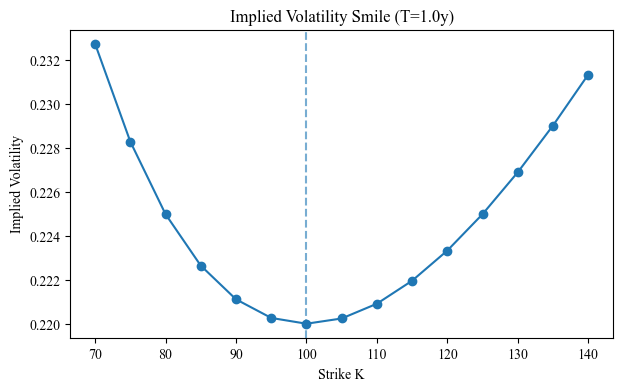

In [14]:
T = 1.0
strikes = np.arange(70, 141, 5)  
# A smooth "true" smile (example): convex in moneyness + mild level
def true_smile(K):
    m = np.log(K / S)  # log-moneyness at pricing time (using K vs S)
    return 0.20 + 0.10*(m**2) + 0.02  # base + convex term + small lift

# Synthetic market CALL prices from the smile
prices = np.array([black_scholes_price(S, K, T, r, true_smile(K), option_type="call")
                   for K in strikes])

# Invert to implied vols
iv = np.array([implied_volatility(price=p, S=S, K=K, T=T, r=r, option_type="call")
               for p, K in zip(prices, strikes)])

# Plot
plt.figure(figsize=(7,4))
plt.plot(strikes, iv, marker="o")
plt.axvline(S, ls="--", alpha=0.6)  # ATM ~ K=S
plt.title(f"Implied Volatility Smile (T={T}y)")
plt.xlabel("Strike K")
plt.ylabel("Implied Volatility")
plt.show()


 **Reading the smile**
- **ATM** (near $K \approx S$) often shows the **lowest** or **highest** vol depending on market skew/convexity.
-  Deep ITM/OTM options tend to carry **higher IV** when wings are fat.


##  Term structure at fixed strike

Now fix $K$ and vary $T$. We specify a simple increasing term structure $\sigma(T)$,
price calls, and recover IVs to plot **IV vs maturity**.


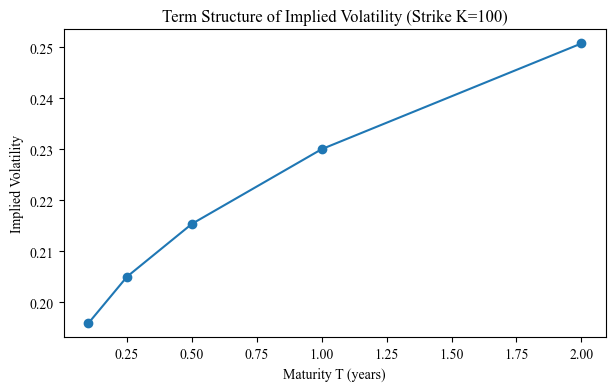

In [15]:
K = 100.0
maturities = np.array([0.1, 0.25, 0.5, 1.0, 2.0])

# A smooth "true" term structure (example)
def true_term(T):
    return 0.18 + 0.05*np.sqrt(T)  # gently increasing with T

# Prices and IV inversion
ts_prices = np.array([black_scholes_price(S, K, T, r, true_term(T), option_type="call")
                      for T in maturities])
ts_iv = np.array([implied_volatility(price=p, S=S, K=K, T=T, r=r, option_type="call")
                  for p, T in zip(ts_prices, maturities)])

# Plot
plt.figure(figsize=(7,4))
plt.plot(maturities, ts_iv, marker="o")
plt.title("Term Structure of Implied Volatility (Strike K=100)")
plt.xlabel("Maturity T (years)")
plt.ylabel("Implied Volatility")
plt.show()


## 3D Implied Volatility Surface

We construct a **volatility surface** by:

1. Choosing a grid of **strikes** $K$ and **maturities** $T$.
2. Defining a smooth "true" surface $\sigma_{\text{true}}(K,T)$ with:
   - A **smile** across strikes (higher vol for deep ITM/OTM options).
   - A mild **term premium** as maturity increases.
3. Generating synthetic **market prices** with the Black–Scholes formula
   using $\sigma_{\text{true}}(K,T)$.
4. Inverting these prices back to implied volatilities using
   `implied_vol_surface`, which applies Brent’s root-finder cell by cell.
5. Plotting the recovered implied vols as a **3D surface**:

- **X-axis**: Strike price $K$  
- **Y-axis**: Maturity $T$ (in years)  
- **Z-axis**: Implied Volatility $\sigma_{\text{imp}}$

This surface clearly shows both **smile effects** (curvature along strikes)
and **term structure** (drift in volatility across maturities).



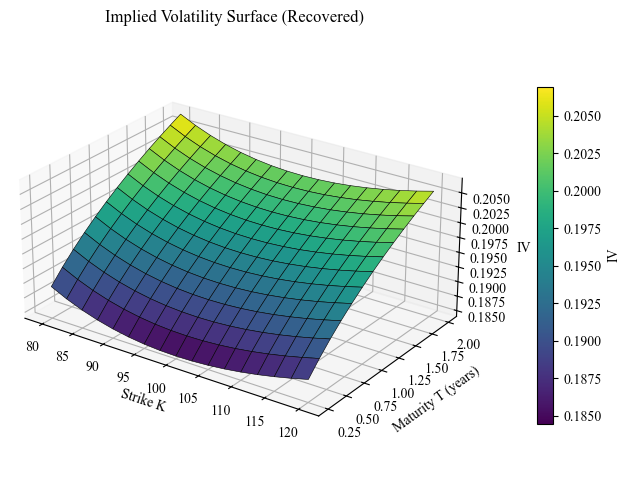

In [23]:


# Choose a *non-flat* grid so the surface shows curvature
strikes    = np.linspace(80, 120, 17)      # 17 K points
maturities = np.linspace(0.25, 2.0, 13)    # 13 T points

# Generating "true" surface used to make synthetic prices
def true_surface(K, T):
    m = np.log(K / S)                      # log-moneyness
    return 0.18 + 0.10*(m**2) + 0.02*np.log1p(T)  # smile in K + term premium

# ----- Build price matrix (shape: len(T) x len(K)) -----
price_mat = np.zeros((len(maturities), len(strikes)))
for i, T in enumerate(maturities):
    for j, K in enumerate(strikes):
        sig = true_surface(K, T)
        price_mat[i, j] = black_scholes_price(S, K, T, r, sig, option_type="call")

# ----- Invert to implied vols -----
iv_surf = implied_vol_surface(
    price_mat, S=S, strikes=strikes, maturities=maturities, r=r, option_type="call"
)

# Meshgrid for plotting
Kmesh, Tmesh = np.meshgrid(strikes, maturities)

# ----- 3D surface plot (improved styling) -----
vmin, vmax = np.nanmin(iv_surf), np.nanmax(iv_surf)

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(
    Kmesh, Tmesh, iv_surf,
    cmap="viridis", vmin=vmin, vmax=vmax,
    rstride=1, cstride=1,
    linewidth=0.4, edgecolor="k",
    antialiased=True
)
ax.view_init(elev=25, azim=-55)           # nicer angle
ax.set_box_aspect((1.4, 1.0, 0.6))        # aspect (x,y,z)
ax.set_title("Implied Volatility Surface (Recovered)")
ax.set_xlabel("Strike K"); ax.set_ylabel("Maturity T (years)"); ax.set_zlabel("IV")
cbar = fig.colorbar(surf, ax=ax, shrink=0.75, pad=0.10); cbar.set_label("IV")
plt.tight_layout(); plt.show()


## Implied Volatility Surface vs Moneyness (K/F) and Maturity (T)

We plot the implied volatility surface as a function of **moneyness** and **maturity**:

- **Moneyness (market convention):** $ M = \frac{K}{F} $, where $ F = S e^{rT} $.
- This removes carry effects and matches how surfaces are commonly quoted.

**Pipeline**
1. Compute a matrix of option prices $ P(T_i, K_j) $.
2. Invert to get the IV surface $ \sigma_{\text{imp}}(T_i, K_j) $.
3. Build the moneyness grid $ M(T_i, K_j) $.
4. Plot IV as a function of $ (M, T) $.

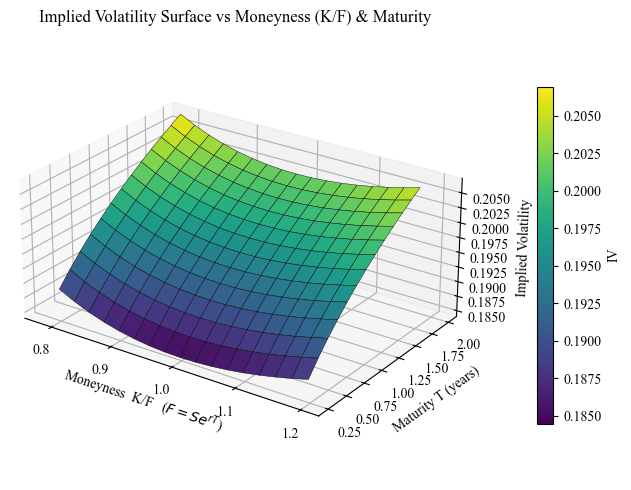

In [21]:
# ----- Build price matrix P(T, K) -----
price_mat = np.zeros((len(maturities), len(strikes)))
for i, T in enumerate(maturities):
    for j, K in enumerate(strikes):
        sig = true_surface(K, T)
        price_mat[i, j] = black_scholes_price(S, K, T, r, sig, option_type="call")

# ----- Invert to implied vols (IV surface σ_imp(T, K)) -----
iv_surf = implied_vol_surface(
    price_mat, S=S, strikes=strikes, maturities=maturities, r=r, option_type="call"
)

# ----- Build moneyness grid (market-standard K/F) -----
M = moneyness_grid(strikes, maturities, S=S, r=r, kind="K_over_F")
Tgrid = np.tile(maturities[:, None], (1, len(strikes)))  # shape matches iv_surf

# Given: S, r, strikes, maturities, iv_surf (shape: len(T) x len(K))
M = moneyness_grid(strikes, maturities, S=S, r=r, kind="K_over_F")
Tgrid = np.tile(maturities[:, None], (1, len(strikes)))

vmin, vmax = np.nanmin(iv_surf), np.nanmax(iv_surf)

# --- 3D surface ---
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(
    M, Tgrid, iv_surf,
    cmap="viridis", vmin=vmin, vmax=vmax,
    rstride=1, cstride=1,
    linewidth=0.3, edgecolor="k", antialiased=True
)
ax.view_init(elev=25, azim=-55)
ax.set_box_aspect((1.4, 1.0, 0.6))
ax.set_title("Implied Volatility Surface vs Moneyness (K/F) & Maturity")
ax.set_xlabel("Moneyness  K/F   ($F = S e^{rT}$)")
ax.set_ylabel("Maturity T (years)")
ax.set_zlabel("Implied Volatility")
cbar = fig.colorbar(surf, ax=ax, shrink=0.75, pad=0.10); cbar.set_label("IV")
plt.tight_layout(); plt.show()


> **Note on similarity of plots:**  
> The 3D surface plot and the 2D heatmap may look very similar because they
> represent the *same underlying data* — the implied volatility surface
> $\sigma_{\text{imp}}(M, T)$ as a function of moneyness and maturity.  
> 
> - In the **3D surface plot**, implied volatility is shown on the **vertical z-axis**.  
> - In the **2D heatmap**, the same values are mapped into **colors** on a flat plane.  
> 
> Both are simply two different visual perspectives of the same surface,
> which is why their patterns (curvature, skew, term structure) appear identical.
